In [17]:
%load_ext autoreload
%autoreload 2
from objectives import *
from pebsi.processing.plotting_fxns import *
import pebsi.processing.gridsearch_processing as gsproc
from seasonal_error import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


==========================Z==========================
Weights:
    winter     best
         1      ('3.25', '-8.5')
       1.0      ('3.25', '-8.5')
Winter bias: 0.18    Summer bias: 0.32
Winter MAE: 0.35    Summer MAE: 0.87
==========================T==========================
Weights:
    winter     best
         1      ('3.5', '-8')
       1.0      ('3.5', '-8')
Winter bias: 0.10    Summer bias: 0.57
Winter MAE: 0.15    Summer MAE: 0.57
==========================mean==========================
Weights:
    winter     best
         1      ('3.25', '-8.5')
       1.0      ('3.25', '-8.5')
Winter bias: 0.09    Summer bias: 0.47
Winter MAE: 0.25    Summer MAE: 0.75


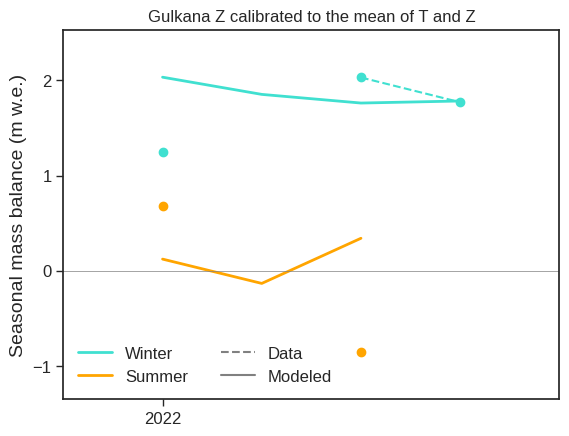

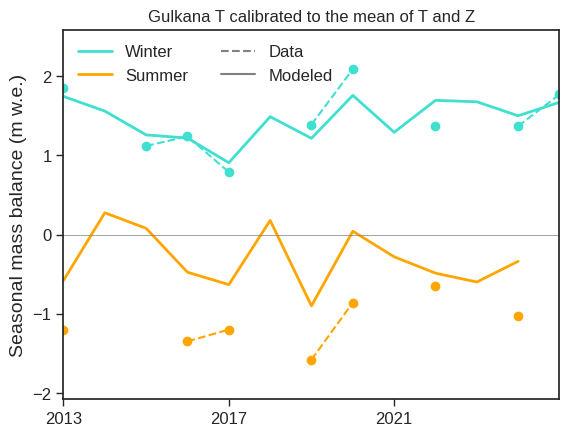

In [20]:
# ===== CALIBRATE ON GULKANA =====
sites = ['Z','T']
gsproc.sitedict['firn'] = sites
result_dict = gsproc.get_result_dict(force_redo=True, parse_runs=['firn'])

# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['winter']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims, run_type='firn')

# ===== FIND BEST PARAMETERS =====
best_dict = {}
for site in gsproc.sitedict['firn']+['mean']:
    print(f'=========================={site}==========================')
    best_by = gsproc.get_best_normalized(all_error, result_dict, prints=True, site=site)
    best = best_by[-1]
    best_dict[site] = best
    if site != 'mean':
        ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
        # fig, ax = plot_seasonal_mass_balance(ds)
        # ax.set_title(ds.glacier.capitalize() + ' '+site,fontsize=12)
        winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
        print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
        winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
        print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
    else:
        winter_error = result_dict[best[0]][best[1]][site]['winter_ME']
        summer_error = result_dict[best[0]][best[1]][site]['summer_ME']
        print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
        winter_error = result_dict[best[0]][best[1]][site]['winter_MAE']
        summer_error = result_dict[best[0]][best[1]][site]['summer_MAE']
        print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
        for site in ['Z','T']:
            ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
            fig, ax = plot_seasonal_mass_balance(ds)
            ax.set_title(ds.glacier.capitalize() + ' '+site+' calibrated to the mean of T and Z',fontsize=12)
        best_gulkana = best

Before precip adjustment
Winter bias: -0.10    Summer bias: -0.00
Winter MAE: 0.17    Summer MAE: 0.16
After precip adjustment
Winter bias: 0.04    Summer bias: 0.04
Winter MAE: 0.17    Summer MAE: 0.18


(<Figure size 640x480 with 1 Axes>,
 <Axes: ylabel='Seasonal mass balance (m w.e.)'>)

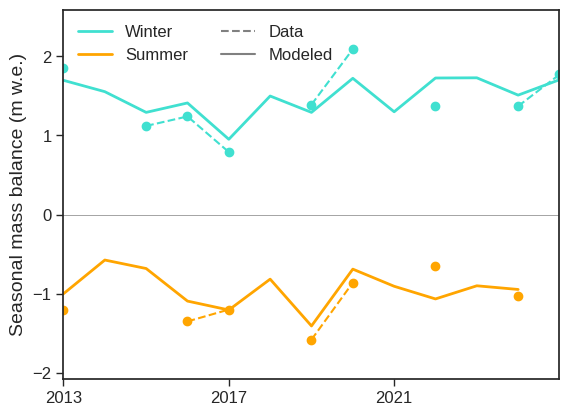

In [19]:
ds = gsproc.get_any(result_dict, best[0], best[1], 'T', run_type='firn')
winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
print('Before precip adjustment')
print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
ds['accum'] *= 1.1
print('After precip adjustment')
winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
plot_seasonal_mass_balance(ds)

==========================EC==========================
Weights:
    winter     summer     best
         1          0      ('2', '-8')
         0          1      ('1.5', '-8.5')
       0.5        0.5      ('1.75', '-8.5')


Winter bias: -0.12    Summer bias: 0.03
Winter MAE: 0.39    Summer MAE: 0.38


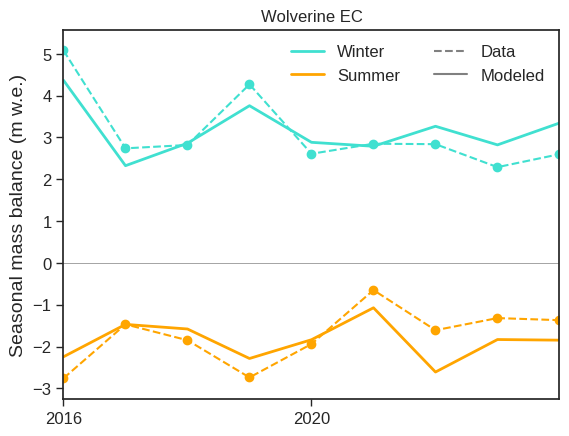

In [14]:
# ===== CALIBRATE ON WOLVERINE =====
gsproc.sitedict['firn'] = ['EC']
result_dict = gsproc.get_result_dict(force_redo=True, parse_runs=['firn'])

# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['winter','summer']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims, run_type='firn')

# ===== FIND BEST PARAMETERS =====
best_dict = {}
for site in ['EC']:
    print(f'=========================={site}==========================')
    best_by = gsproc.get_best_normalized(all_error, result_dict, prints=True, site=site)
    best = best_by[-1]
    best_dict[site] = best
    ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
    fig, ax = plot_seasonal_mass_balance(ds)
    ax.set_title(ds.glacier.capitalize() + ' '+site,fontsize=12)
    winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
    print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
    winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
    print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
best_wolverine = best

==========================KPS==========================
Weights:
    winter     summer     best
         1          0      ('2', '-8.5')
         0          1      ('1', '-8')
       0.5        0.5      ('2', '-4.5')


Winter bias: -0.26    Summer bias: -0.18
Winter MAE: 0.58    Summer MAE: 0.98


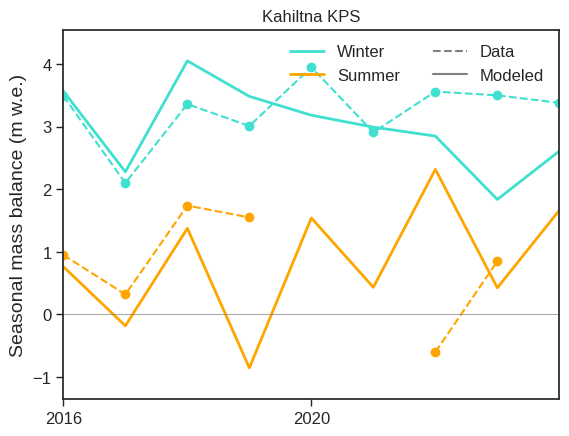

In [15]:
# # ===== CALIBRATE ON KAHILTNA =====
gsproc.sitedict['firn'] = ['KPS']
result_dict = gsproc.get_result_dict(force_redo=True, parse_runs=['firn'])

# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['winter','summer']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims, run_type='firn')

# ===== FIND BEST PARAMETERS =====
best_dict = {}
for site in ['KPS']:
    print(f'=========================={site}==========================')
    best_by = gsproc.get_best_normalized(all_error, result_dict, prints=True, site=site)
    best = best_by[-1]
    best_dict[site] = best
    ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
    fig, ax = plot_seasonal_mass_balance(ds)
    ax.set_title(ds.glacier.capitalize() + ' '+site,fontsize=12)
    winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
    print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
    winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
    print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
best_kahiltna = best

In [15]:
print(f'Gulkana parameters:     kp {best_gulkana[0]}        lapse_rate {best_gulkana[1]}')
print(f'Wolverine parameters:   kp {best_wolverine[0]}      lapse_rate {best_wolverine[1]}')
print(f'Kahiltna parameters:    kp {best_kahiltna[0]}      lapse_rate {best_kahiltna[1]}')

Gulkana parameters:     kp 3.5        lapse_rate -5
Wolverine parameters:   kp 1.75      lapse_rate -8.5
Kahiltna parameters:    kp 2      lapse_rate -4.5


Use these parameters to perform a long simulation (1980-2025) and create the forcings file below

In [5]:
import xarray as xr
import pandas as pd

# open PEBSI simulation and associated climate (contains rainfall)
site = 'KPS'
glacier = 'Gulkana' if site in ['Z','T'] else 'Wolverine' if site == 'EC' else 'Kahiltna'
ds = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_09_16_long{site}_0.nc')
# ds_tp = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_08_28_long{site}_climate.nc')['tp']
timeres='1d'
forcing_fn = f'/trace/group/rounce/cvwilson/Output/{glacier.lower()}{site}_{timeres}_forcings.csv'

# clip datasets to a common time
# clip_time = pd.date_range('1980-04-15 00:00','2025-04-20 00:00',freq='h')
# ds_tp = ds_tp.sel(time=clip_time)
# ds = ds.sel(time=clip_time)

# # changed output so updated runs have vaporsolid mass flux and old runs just have latent heat
# if 'vaporsolid' in ds.variables:
# get sublimation from any negative vaporsolid mass fluxes in m w.e.
ds['vaporsolid'][ds['vaporsolid'] > 0] = 0
ds['sublim'] = ds['vaporsolid']
# else:
#     # get sublimation from latent heat
#     ds['sublim'] = ds.latent*3600/(2849000 * 1000) # latent (J s-1 m-2) * dt (s) / density_water (kg m-3) / lh_sub (J kg-1) --> m w.e.
#     ds['sublim'][ds['sublim'] < 0] = 0
#     ds['sublim'][ds.surftemp.values >= 0] = 0
#     ds['sublim'] *= -1

# get rain from total precipitation - accumulation (mask out any erraneous negatives)
# ds['rain'] = ds_tp - ds['accum']
# ds['rain'][ds['rain'] < 0] = 0

# change units of surftemp
ds['surftemp'] += 273.15

# get surface density
layer_thickness = ds.layerheight * 100
cumulative_depth = layer_thickness.cumsum(dim='layer')
mask = cumulative_depth <= 50
weighted_density = ds.layerdensity * layer_thickness.where(mask)
valid_thickness = layer_thickness.where(mask).sum(dim='layer')
surfdens = weighted_density.sum(dim='layer') / valid_thickness
ds['surfdens'] = surfdens

# resample to the specified resolution with sum (mass balance terms) and mean (surface temp)
ds_mb = ds[['melt','accum','rainfall','sublim']].resample(time=timeres).sum()
ds_mb *= 1000   # convert m w.e. to kg m-2
ds_other = ds[['surftemp','surfdens']].resample(time=timeres).mean()

# merge datasets and rename
data_in = xr.merge([ds_mb, ds_other])
data_in = data_in.rename_vars({'melt':'SMELT', 'rainfall':'RAIN', 'surftemp':'TS', 'accum':'BDOT','sublim':'SUBLIM','surfdens':'RHOS'})

# store data as a .csv
df = data_in[['BDOT','RAIN','TS','SMELT','SUBLIM']].to_dataframe()
print(forcing_fn)
df.to_csv(forcing_fn)

/trace/group/rounce/cvwilson/Output/kahiltnaKPS_1d_forcings.csv


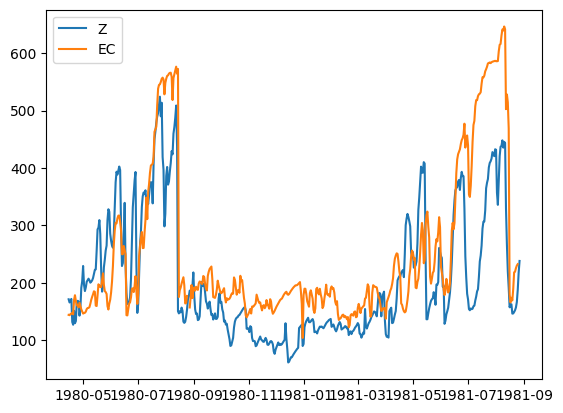

In [23]:
df1 = pd.read_csv('/trace/group/rounce/cvwilson/Output/gulkanaZ_1d_forcings_wsrho.csv')
df2 = pd.read_csv('/trace/group/rounce/cvwilson/Output/wolverineEC_1d_forcings_wsrho.csv')
plt.plot(pd.to_datetime(df1.time.values[:500]), df1.RHOS[:500],label='Z')
plt.plot(pd.to_datetime(df2.time.values[:500]), df2.RHOS[:500],label='EC')
plt.legend()
plt.show()